## Import Libraries

In [1]:
import tweepy 
import pandas as pd 
import numpy as np 
import csv 
import re 
import string 
import glob 
import random 
import requests 
from PIL import Image 
import matplotlib.pyplot as plt 
import nltk
from nltk.corpus import stopwords, words
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import plotly.express as px 
import chart_studio.tools as cst 
from textblob import TextBlob
import chart_studio.plotly as py 
import plotly.offline as pyo 
import plotly.io as pio 
import plotly.graph_objects as go 
from plotly.subplots import make_subplots
from wordcloud import WordCloud
from emot.emo_unicode import UNICODE_EMOJI, EMOTICONS_EMO
import joblib
import gensim
from collections import Counter
import re
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

## Tweets Mining

In [2]:
api_key = 'XXXXXXXXXXXXXXXXXX'# Enter your API key here
api_secret = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXX'# Enter you API security Key here
access_key= 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'# Enter you Access Key here
access_secret = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'# Enter you Access security Key here

### API Authentication 

#### Returns  "Authentication Successful " if sucessful or returns "Authentication Failed" if failed

In [3]:
auth = tweepy.OAuthHandler(api_key, api_secret) # Pass the API key and Security key here for Authentication
auth.set_access_token(access_key, access_secret) # Pass the Access key and secret key for Authentication
api = tweepy.API(auth,wait_on_rate_limit=True,wait_on_rate_limit_notify=True) # Using this it will Auutomatically sleep when APi limit is reached
# Verify the Authentication 
try: 
    api.verify_credentials() 
    print("Authentication Successful ") 
except: 
    print("Authentication Failed")

Authentication Successful 


#### Creating a User defined function for Tweets Mining

In [4]:
def retrive_tweets(query, no_tweets, last_id, file):
    # Using this Function We will collect the tweets
    tweet_list = [tweets for tweets in tweepy.Cursor(api.search,
                                                    q = query,
                                                    id = last_id,
                                                    lang = 'en',
                                                    tweet_mode = 'extended').items(no_tweets)]
    # Here we are retriving the tweets from the tweeter database and one by one and storing it in the following variable
    for tweet in tweet_list[::-1]:
        tweet_id = tweet.id
        created_at = tweet.created_at
        tweet_text = tweet.full_text
        location = tweet.user.location
        retweet = tweet.retweet_count
        favorite = tweet.favorite_count
        with open('Data/'+file+'.csv', 'a', encoding='utf-8') as csvFile3:
            csv_writer = csv.writer(csvFile3, delimiter = ',')
            csv_writer.writerow([tweet_id, created_at, tweet_text,location, retweet, favorite])

In [5]:
# Specify the Search word
search_word = "\"covid\""
# This Queary will exclude retweets, Links, replies
query = search_word + " -filter:links AND -filter:retweets AND -filter:replies" 
with open('DATA/covid.csv',encoding='utf-8') as data:
    # Retrving the most resent tweet ID
    last_tweet = int(list(csv.reader(data))[1][0])
retrive_tweets(query, 2500, last_tweet, "covid")

In [ ]:
# Specify the Search word
search_word = "\"new Year\""
# This Queary will exclude retweets, Links, replies
query = search_word + " -filter:links AND -filter:retweets AND -filter:replies" 
with open('DATA/_2022.csv',encoding='utf-8') as data:
    # Retrving the most resent tweet ID
    last_tweet = int(list(csv.reader(data))[1][0])
retrive_tweets(query, 2500, last_tweet, "_2022")

#### Combining all the CSV files in the folder into a single dataframes

In [10]:
# Add your path here 
path = r'./DATA'
# This will retrive all the csv files in the folder
files = glob.glob(path + '/*.csv')
tweets = []
for file_name in files:
    df = pd.read_csv(file_name, index_col=None, header=0)
    # Appending the CSV to the list
    tweets.append(df)
# Converting it to the DataFrames
tweets_data = pd.concat(tweets, axis=0,ignore_index=True)
tweets_data.head()

,tweet_id,created_at,tweet,location,retweet,favorite
0,1477056205155710000,12/31/21 23:16,"To the best followers in the world,\n\nI wish ...",Become an Alpha:,1,0
1,1477056244221460000,12/31/21 23:17,2022; year of everyone getting into fazee and ...,"Hamburger, France",0,1
2,1477056324391290000,12/31/21 23:17,Hoping 2022 year brings a lot of great thing t...,NaN,0,9
3,1477056513109860000,12/31/21 23:18,"HAPPY NEW 2022 YEAR, ENJOY YOUR EVERY SECOND T...",Introvertopia,0,2
4,1477056516570200000,12/31/21 23:18,Welcome 2022 year of Greater Achievements and ...,NaN,0,1


## Data Cleaning

In [11]:
tweets_data.shape

(59363, 6)

In [12]:
# Checking the duplicate value in the dataset
tweets_data.duplicated(subset='tweet_id').sum() 

9995

In [13]:
# Droping the duplicate dataset
tweets_data=tweets_data.drop_duplicates(subset=['tweet_id']) 

In [14]:
# Again check the duplicate values
tweets_data.duplicated(subset='tweet_id').sum() 

0

In [15]:
tweets_data.shape

(49368, 6)

In [17]:
# Check for NAN values in the data
tweets_data.isna().any() 

tweet_id      False
created_at    False
tweet         False
location       True
retweet       False
favorite      False
dtype: bool

In [18]:
# Replace NAN values in the location columnn with No location
tweets_data['location']=tweets_data['location'].fillna('No location') 

In [19]:
# Again check the NAN values
tweets_data.isna().any() 

tweet_id      False
created_at    False
tweet         False
location      False
retweet       False
favorite      False
dtype: bool

In [20]:
# Using NLTK stop words plus userdefined stopwords
stop_words = list(nltk.corpus.stopwords.words('english'))
user_stop_words = ['2020', 'year', 'many', 'much', 'amp', 'next', 'cant', 'wont', 'hadnt',
                    'havent', 'hasnt', 'isnt', 'shouldnt', 'couldnt', 'wasnt', 'werent',
                    'mustnt', "'", '...', '..', '.', '.....', '....', 'been…', 'one', 'two',
                    'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'aht',
                    've', 'next']
alphabets = list(string.ascii_lowercase)
stop_words = stop_words + user_stop_words + alphabets
# Retriving all wors from english
word_list = words.words()
# reterving the list of emojies
emojis = list(UNICODE_EMOJI.keys())

## Tweets Processing

In [21]:
# This function will remove punctuation, links, emojis and stopwords
def process_tweets(tweets):
    tweets = tweets.lower()  
    # Remove URLS
    tweets = re.sub(r"http\S+|www\S+|https\S+", '', tweets, flags=re.MULTILINE)
    # Removing # and @ from the data
    tweets = re.sub(r'\@\w+|\#|\d+', '', tweets)
    # Removing Stopwords
    tweet_tokens = word_tokenize(tweets)
    filtered_words = [w for w in tweet_tokens if w not in stop_words]
    filtered_words = [w for w in filtered_words if w not in emojis]
    filtered_words = [w for w in filtered_words if w in word_list]

    # Removing Punctuation 
    unpunctuated_words = [char for char in filtered_words if char not in string.punctuation]
    unpunctuated_words = ' '.join(unpunctuated_words)
    # Joining words with the space in between them
    return "".join(unpunctuated_words)

def adjectives(tweets):
    tweets = word_tokenize(tweets)
    tweets = [w for (w, tag) in pos_tag(tweets)
             # pos_tag module in NLTK library
             if tag == 'JJ']
    return ' '.join(tweets)

# function to return words to their base form using Lemmatizer
def preprocessSentiment(tweets):
    token = word_tokenize(tweets)
    # instatiate an object WordNetLemmatizer Class
    lemmatizer = WordNetLemmatizer() 
    lemma_words = [lemmatizer.lemmatize(w) for w in token]
    return " ".join(lemma_words)
    

In [22]:
# Example of the process tweets
print(process_tweets("I tested positive for covid today which means I can't go see my family tomorrow :(( I would appreciate some huggies"))

tested positive covid today ca go see family tomorrow would appreciate


In [23]:
# Applying the preProcess function and storing it to the new columns Processed_Tweets
tweets_data['Process_Tweets'] = tweets_data['tweet'].apply(process_tweets)

In [24]:
# Applying the getAdjectives function and storing it to the new columns Tweets_Adjectives
tweets_data['Tweets_Adjectives'] = tweets_data['Process_Tweets'].apply(adjectives)

In [25]:
# Applying the preprocessTweetsSentiments function to an Processed_Tweets and storing it to the new columns 
tweets_data['Tweets_Sentiments'] = tweets_data['Process_Tweets'].apply(preprocessSentiment)

In [26]:
tweets_data.head()

,tweet_id,created_at,tweet,location,retweet,favorite,Process_Tweets,Tweets_Adjectives,Tweets_Sentiments
0,1477056205155710000,12/31/21 23:16,"To the best followers in the world,\n\nI wish ...",Become an Alpha:,1,0,best world wish happy successful,happy successful,best world wish happy successful
1,1477056244221460000,12/31/21 23:17,2022; year of everyone getting into fazee and ...,"Hamburger, France",0,1,everyone getting gaming,,everyone getting gaming
2,1477056324391290000,12/31/21 23:17,Hoping 2022 year brings a lot of great thing t...,No location,0,9,lot great thing everyone,great,lot great thing everyone
3,1477056513109860000,12/31/21 23:18,"HAPPY NEW 2022 YEAR, ENJOY YOUR EVERY SECOND T...",Introvertopia,0,2,happy new enjoy every second night,happy new second,happy new enjoy every second night
4,1477056516570200000,12/31/21 23:18,Welcome 2022 year of Greater Achievements and ...,No location,0,1,welcome greater ace,welcome,welcome greater ace


In [27]:
# encoding and Saving the processed data to an csv File
tweets_data.to_csv('Tweets_Processed.csv',encoding='utf-8-sig', index=False) 

## Exploratory Data Analysis(EDA)

In [51]:
tweets_long_string = tweets_data['Process_Tweets'].tolist()
tweets_long_string = " ".join(tweets_long_string)

In [68]:
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(210, 100%%, %d%%)" % random.randint(50, 70)
#     return "hsl(10, 100%%, %d%%)" % random.randint(50, 70)
#     return "hsl(114, 100%%, %d%%)" % random.randint(50, 70)

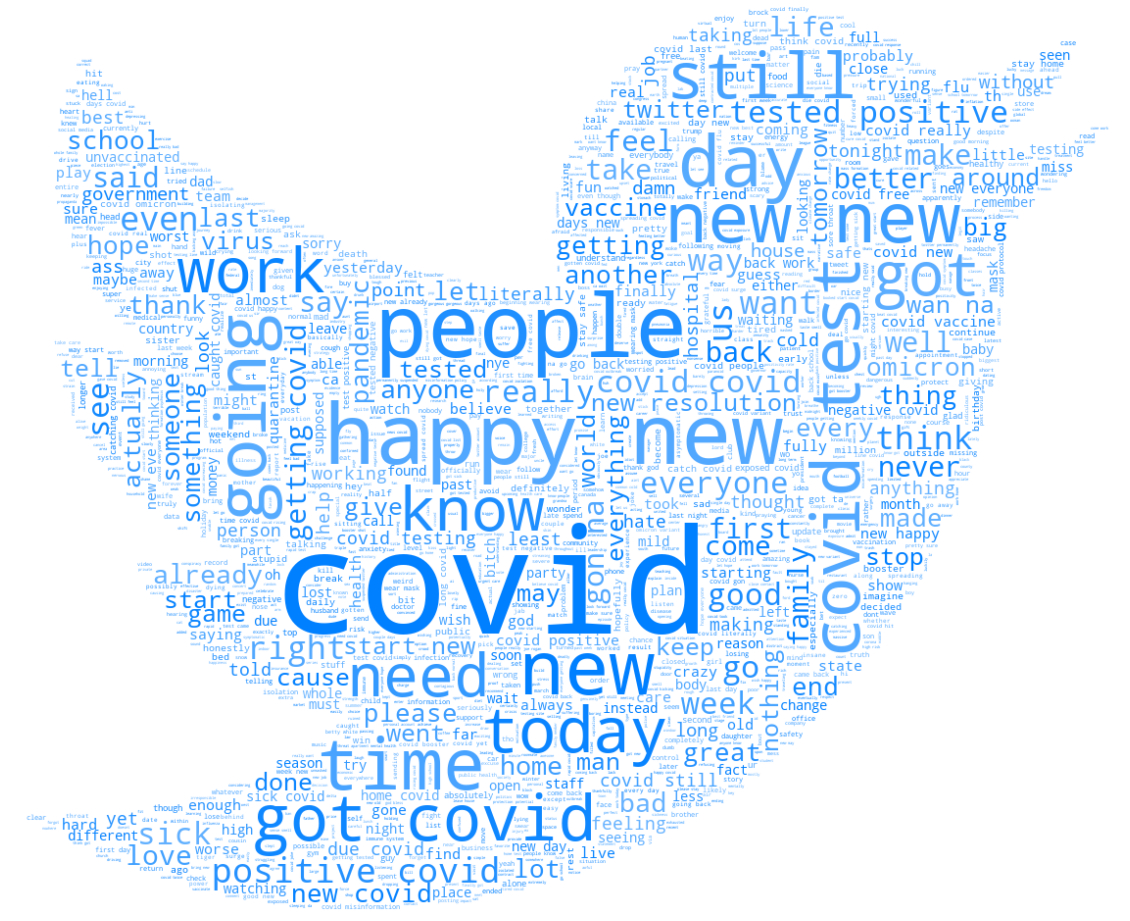

In [69]:
image = np.array(Image.open('/Users/girishbudhrani/Desktop/G drive/Projects/Twiter/Mark 1/tweet_sentiment/firstpp/image/twitter_image.png'))
word_cloud_tweet = WordCloud(background_color='white', max_words=1500, mask=image)

word_cloud_tweet.generate(tweets_long_string)

# display the word cloud
fig = plt.figure()
fig.set_figwidth(20)  # set width
fig.set_figheight(18)  # set height
plt.axis('off')
plt.imshow(word_cloud_tweet.recolor(color_func=color_func, random_state=3),
           interpolation="bilinear")

In [31]:
word_cloud_tweet.to_file("wordcloud.png")

In [79]:
# Storing all words into an list
tweets_string = tweets_data['Process_Tweets'].tolist()
tweets_list = []
for temp in tweets_string:
    temp = temp.split()
    for i in temp:
        tweets_list.append(i)

In [80]:
# Using builting functions to determine frequency
counts = Counter(tweets_list)
data = pd.DataFrame.from_dict(counts,orient='index').reset_index()
data.columns = ['Words','Count']
data.sort_values(by = 'Count', ascending=False, inplace=True)

In [81]:
data.head()

,Words,Count
567,covid,30713
11,new,12263
28,get,4471
43,people,3595
132,like,3553


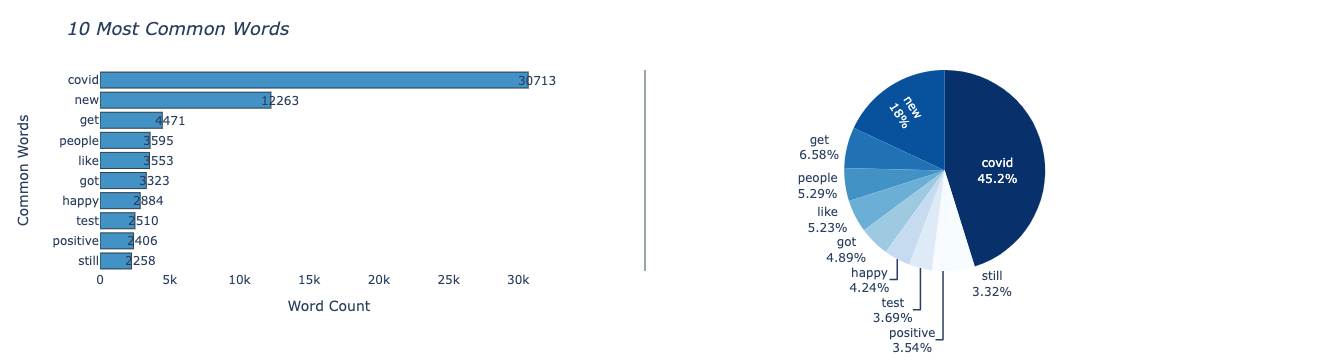

In [87]:
colors = ['rgb(8,48,107)', 'rgb(8,81,156)', 'rgb(33,113,181)', 'rgb(66,146,198)',
              'rgb(107,174,214)', 'rgb(158,202,225)', 'rgb(198,219,239)',
              'rgb(222,235,247)', 'rgb(247,251,255)', 'rgb(247,253,255)']

# Set layout for Plotly Subplots
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "xy"}, {"type": "domain"}]],
                    vertical_spacing=0.001)

# Add First Plot
fig.add_trace(go.Bar(x=data['Count'].head(10), y=data['Words'].head(10), marker=dict(color='rgba(66,146,198, 1)',
                                                                                 line=dict(color='Black'), ),
                     name='Bar Chart', orientation='h'), 1, 1)

# Add Second Plot
fig.add_trace(go.Pie(labels=data['Words'].head(10), values=data['Count'].head(15), textinfo='label+percent',
                     insidetextorientation='radial', marker=dict(colors=colors, line=dict(color='DarkSlateGrey')),
                     name='Pie Chart'), 1, 2)
# customize layout
fig.update_layout(shapes=[dict(type="line", xref="paper", yref="paper", x0=0.5, y0=0, x1=0.5, y1=1.0,
                               line_color='DarkSlateGrey', line_width=1)])

# customize plot title
fig.update_layout(showlegend=False,
                  title=dict(text=" <i>10 Most Common Words</i>",
                             font=dict(size=18, )))

# Customize backgroound, margins, axis, title
fig.update_layout(yaxis=dict(showgrid=False,
                             showline=False,
                             showticklabels=True,
                             domain=[0, 1],
                             categoryorder='total ascending',
                             title=dict(text='Common Words', font_size=14)),
                  xaxis=dict(zeroline=False,
                             showline=False,
                             showticklabels=True,
                             showgrid=True,
                             domain=[0, 0.42],
                             title=dict(text='Word Count', font_size=14)),
                  margin=dict(l=100, r=20, t=70, b=70),
                  paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)')

# Specify X and Y values for Annotations
x = data['Count'].head(10).to_list()
y = data['Words'].head(10).to_list()

# Show annotations on plot
annotations = [dict(xref='x1', yref='y1', x=xa + data['Count'][0], y=ya, text=str(xa), showarrow=False) for xa, ya in zip(x, y)]

fig.update_layout(annotations=annotations)
fig.show()

## Sentiment Analysis

In [36]:
# This function is helping to obtain a Subjectivity Score
def get_score(tweets):
    return TextBlob(tweets).sentiment.subjectivity
# This function is helping to obtain a Polarity Score
def get_polarity(tweets):
    return TextBlob(tweets).sentiment.polarity
# This function is helping to obtain a Sentiment category
def get_sentiment(polarity):
    if polarity > 0:
        return "Positive"
    elif polarity < 0:
        return "Negative"
    else:
        return "Neutral"

In [37]:
# Applying the functions and adding them to an new columns
tweets_data['Subjectivity Score']=tweets_data['Tweets_Sentiments'].apply(get_score)
tweets_data['Polarity']=tweets_data['Tweets_Sentiments'].apply(get_polarity)
tweets_data['Sentiment']=tweets_data['Polarity'].apply(get_sentiment)

In [65]:
# To see a quick result
tweets_data['Sentiment'].value_counts()

Positive    19952
Neutral     10908
Negative     9481
Name: Sentiment, dtype: int64

In [39]:
bar_chart = tweets_data['Sentiment'].value_counts().rename_axis('Sentiment').to_frame('Total Tweets').reset_index()

In [74]:
bar_chart['Sentiment']

0    Positive
1     Neutral
2    Negative
Name: Sentiment, dtype: object

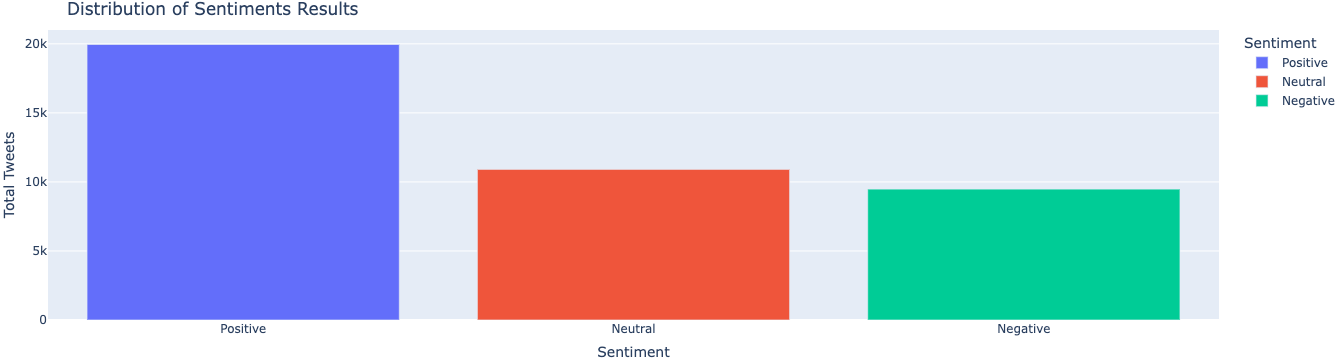

In [40]:
sentiments_barchart = px.bar(bar_chart, x = 'Sentiment', y='Total Tweets', color='Sentiment')

sentiments_barchart.update_layout(title='Distribution of Sentiments Results',
                                  margin={"r": 0, "t": 30, "l": 0, "b": 0})

sentiments_barchart.show() #Display plot. 

In [41]:
table_df = tweets_data.drop((['Process_Tweets','Tweets_Sentiments','Subjectivity Score','Polarity']), axis=1).copy(deep=True)
table_df.head()

,tweet_id,created_at,tweet,location,retweet,favorite,Tweets_Adjectives,Sentiment
0,1477056205155710000,12/31/21 23:16,"To the best followers in the world,\n\nI wish ...",Become an Alpha:,1,0,happy successful,Positive
1,1477056244221460000,12/31/21 23:17,2022; year of everyone getting into fazee and ...,"Hamburger, France",0,1,,Neutral
2,1477056324391290000,12/31/21 23:17,Hoping 2022 year brings a lot of great thing t...,No location,0,9,great,Positive
3,1477056513109860000,12/31/21 23:18,"HAPPY NEW 2022 YEAR, ENJOY YOUR EVERY SECOND T...",Introvertopia,0,2,happy new second,Positive
4,1477056516570200000,12/31/21 23:18,Welcome 2022 year of Greater Achievements and ...,No location,0,1,welcome,Positive


In [42]:
x = table_df.iloc[:, 0:7]
x.shape

(40341, 7)

In [43]:
y = table_df.iloc[:,7]
y.shape

(40341,)

In [44]:
def hashtag_ext(tweet):
    hashtags = []
    for i in tweet:
        temp = re.findall(r"#(\w+)", i)
        hashtags.append(temp)
    return hashtags

In [45]:
hashtags = hashtag_ext(x['tweet'])
hashtags = sum(hashtags,[])

In [46]:
token_tweet = x['tweet'].apply(lambda x: x.split()) 

model_word_vector = gensim.models.Word2Vec(
                    token_tweet,
                    window = 5,
                    min_count = 2,
                    sg = 1,
                    hs = 0,
                    negative = 10,
                    workers = 2,
                    seed = 34)
model_word_vector.train(token_tweet, total_examples= len(x['tweet']), epochs=20)

(14706738, 19434420)

In [47]:
train_corpus = []
for i in range(0, x.shape[0]):
    review = re.sub('[^a-zA-Z]', ' ', x.iloc[i,2])
    review = review.lower()
    review = review.split()
    PS = PorterStemmer()
    # stemming
    review = [PS.stem(word) for word in review if not word in set(stopwords.words('english'))]
    # joining them back with space
    review = ' '.join(review)
    # train_corpus
    train_corpus.append(review)

In [48]:
count_vector = CountVectorizer(max_features = 100)
x = count_vector.fit_transform(train_corpus).toarray()
y = y
print(x.shape)
print(y.shape)

(40341, 100)
(40341,)


In [49]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.25, random_state = 42)

print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(30255, 100)
(10086, 100)
(30255,)
(10086,)


#### Standardizing

In [50]:
sc = StandardScaler()

x_train = sc.fit_transform(x_train)
x_valid = sc.transform(x_valid)

## Performing Models

#### 1) Random Forest Model

In [69]:
model = RandomForestClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_valid)
print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_valid, y_valid))
# calculating the f1 score for the validation set
print("F1 score :", f1_score(y_valid, y_pred,average='micro'))
# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)
joblib.dump(model,"tweet_sentiment/firstpp/model/RF_model")
RF_model = joblib.load("tweet_sentiment/firstpp/model/RF_model")

Training Accuracy : 0.908248476093161
Validation Accuracy : 0.6655744635873586
F1 score : 0.6655744635873586
[[ 915  644  692]
 [ 260 2054  365]
 [ 410  793 3328]]


#### 2) Logistic Regression 

In [70]:
model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(x_train, y_train)
y_pred = model.predict(x_valid)
print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_valid, y_valid))
# calculating the f1 score for the validation set
print("f1 score :", f1_score(y_valid, y_pred,average='micro'))
# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)
joblib.dump(model,"tweet_sentiment/firstpp/model/LR_model")
LR_model = joblib.load("tweet_sentiment/firstpp/model/LR_model")

Training Accuracy : 0.693315950812163
Validation Accuracy : 0.6874537575309164
f1 score : 0.6874537575309164
[[ 888  840  523]
 [ 130 2402  147]
 [ 281 1036 3214]]


#### 3) Decision Tree Classifier

In [71]:
model = DecisionTreeClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_valid)
print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_valid, y_valid))
# calculating the f1 score for the validation set
print("f1 score :", f1_score(y_valid, y_pred,average='micro'))
# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)
joblib.dump(model,"tweet_sentiment/firstpp/model/DT_model")
DT_model = joblib.load("tweet_sentiment/firstpp/model/DT_model")

Training Accuracy : 0.908248476093161
Validation Accuracy : 0.6235070288553007
f1 score : 0.6235070288553007
[[ 979  592  680]
 [ 402 1931  346]
 [ 759  783 2989]]


#### 4) Superior vena cava 

In [72]:
model = SVC()
model.fit(x_train, y_train)
y_pred = model.predict(x_valid)
print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_valid, y_valid))
# calculating the f1 score for the validation set
print("f1 score :", f1_score(y_valid, y_pred,average='micro'))
# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)
joblib.dump(model,"tweet_sentiment/firstpp/model/SVC_model")
SVC_model = joblib.load("tweet_sentiment/firstpp/model/SVC_model")

Training Accuracy : 0.7780909763574222
Validation Accuracy : 0.678575203466864
f1 score : 0.678575203466864
[[ 760  812  679]
 [  89 2344  246]
 [ 229  986 3316]]


#### 5) XG Boost Model

In [73]:
from time import time
start_time = time()
model = XGBClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_valid)
print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_valid, y_valid))
# calculating the f1 score for the validation set
print("f1 score :", f1_score(y_valid, y_pred,average='micro'))
# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)
joblib.dump(model,"tweet_sentiment/firstpp/model/xgboost_model")
xgboost_model = joblib.load("tweet_sentiment/firstpp/model/xgboost_model")
print('\nCPU Time:', round(time() - start_time,2),'/sec')

[13:53:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/girishbudhrani/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



Training Accuracy : 0.7360910468271027
Validation Accuracy : 0.6889335165415919
f1 score : 0.6889335165415919
[[ 891  817  543]
 [ 129 2389  161]
 [ 292 1001 3238]]

CPU Time: 5.37 /sec
